In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

class Simulation:
    def __init__(self, agent_attributes, start_date, end_date, exogenous_data, consumer_bid_data):
        self.agent_attributes = agent_attributes
        self.start_date = start_date
        self.end_date = end_date
        self.exogenous_data = exogenous_data
        self.consumer_bid_data = consumer_bid_data
        self.dates = pd.date_range(self.start_date, self.end_date, freq='H')
        self.agents = []
        self.market = DayAheadMarket()
        self.market_results = []
        self.actual_prices_map = {}
        self.simulated_prices_map = {}
        self.agent_trades = {}

    def create_and_add_agents(self):
        for attributes in self.agent_attributes:
            agent_type = attributes['type'].lower()
            agent_name = attributes['name']
            strategy_class_name = attributes.get('bidding_strategy', '')

            if agent_type == 'consumer':
                strategy = ConsumerBiddingStrategy(consumer_bid_data=self.consumer_bid_data)
                agent = Consumer(name=agent_name, bidding_strategy=strategy)
            else:
                if strategy_class_name == 'NaturalGasBiddingStrategy':
                    strategy = NaturalGasBiddingStrategy(exogenous_data=self.exogenous_data)
                elif strategy_class_name == 'CoalBiddingStrategy':
                    strategy = CoalBiddingStrategy(exogenous_data=self.exogenous_data)
                elif strategy_class_name == 'DammedHydroBiddingStrategy':
                    strategy = DammedHydroBiddingStrategy(exogenous_data=self.exogenous_data)
                elif strategy_class_name == 'ZeroBiddingStrategy':
                    strategy = ZeroBiddingStrategy(exogenous_data=self.exogenous_data)
                elif strategy_class_name == 'MarginalCostBiddingStrategy':
                    strategy = MarginalCostBiddingStrategy(exogenous_data=self.exogenous_data)
                else:
                    strategy = BiddingStrategy()

                agent = Producer(name=agent_name, bidding_strategy=strategy)
                agent.bidding_strategy.train_strategy()
            self.agents.append(agent)

        self.market.agents.extend(self.agents)
        self.agent_trades = {agent.name: {date:0 for date in self.dates} for agent in self.agents}

    def run_day_ahead_market(self):
        for date in self.dates:
            self.market.collect_bids(date)
            market_result = self.market.clear_market(date)
            self.market_results.append(market_result)

            actual_price_row = self.exogenous_data.loc[self.exogenous_data['Date'] == date]
            actual_price = actual_price_row['Ptf Prices'].values[0] if not actual_price_row.empty else None

            simulated_price = market_result['market_clearing_price']
            if actual_price is not None:
                self.actual_prices_map[date] = actual_price
                self.simulated_prices_map[date] = simulated_price

            agent_trades = market_result['agent_trades']
            for agent_name, quantity in agent_trades.items():
                self.agent_trades[agent_name][date] = quantity

            self.market.bids = []


class DayAheadMarket:
    def __init__(self):
        self.agents = []
        self.bids = []
        self.market_prices = []

    def collect_bids(self, date):
        self.bids.clear()
        for agent in self.agents:
            new_bids = agent.submit_bid(date)
            if new_bids:
                self.bids.extend(new_bids)

    def clear_market(self, date):
        supply_bids = [bid for bid in self.bids if isinstance(bid.agent, Producer)]
        demand_bids = [bid for bid in self.bids if isinstance(bid.agent, Consumer)]
        supply_bids.sort(key=lambda x: x.price)
        demand_bids.sort(key=lambda x: -x.price)
        s_i, d_i = 0, 0
        total_traded_quantity = 0
        market_clearing_price = None
        agent_trades = {agent.name: 0 for agent in self.agents}

        while s_i < len(supply_bids) and d_i < len(demand_bids):
            if supply_bids[s_i].price <= demand_bids[d_i].price:
                traded_quantity = min(supply_bids[s_i].quantity, demand_bids[d_i].quantity)
                market_clearing_price = (supply_bids[s_i].price + demand_bids[d_i].price) / 2
                total_traded_quantity += traded_quantity
                agent_trades[supply_bids[s_i].agent.name] += traded_quantity
                agent_trades[demand_bids[d_i].agent.name] -= traded_quantity
                supply_bids[s_i].quantity -= traded_quantity
                demand_bids[d_i].quantity -= traded_quantity
                if supply_bids[s_i].quantity == 0:
                    s_i += 1
                if demand_bids[d_i].quantity == 0:
                    d_i += 1
            else:
                break

        self.market_prices.append(market_clearing_price)
        market_result = {'Date': date, 'market_clearing_price': market_clearing_price,
                         'total_traded_quantity': total_traded_quantity, 'agent_trades': agent_trades}
        return market_result


class Agent:
    def __init__(self, name):
        self.name = name
        self.dates = []


class Producer(Agent):
    def __init__(self, name, bidding_strategy):
        super().__init__(name)
        self.bidding_strategy = bidding_strategy

    def submit_bid(self, date):
        self.bidding_strategy.create_bid(date)
        bids = []
        for bid_info in self.bidding_strategy.bidding_prices_quantities:
            if bid_info['quantity'] > 0:
                bids.append(Bid(agent=self, quantity=bid_info['quantity'], price=bid_info['price']))
        if bids:
            self.dates.append(date)
            return bids
        else:
            return []


class Consumer(Agent):
    def __init__(self, name, bidding_strategy):
        super().__init__(name)
        self.bidding_strategy = bidding_strategy

    def submit_bid(self, date):
        self.bidding_strategy.create_bid(date)
        bids = []
        for bid_info in self.bidding_strategy.bidding_prices_quantities:
            if bid_info['quantity'] > 0:
                bids.append(Bid(agent=self, quantity=bid_info['quantity'], price=bid_info['price']))
        if bids:
            self.dates.append(date)
            return bids
        else:
            return []


class BiddingStrategy:
    def __init__(self):
        self.bidding_prices_quantities = []

    def train_strategy(self):
        pass

    def create_bid(self, date):
        self.bidding_prices_quantities = []


class ConsumerBiddingStrategy(BiddingStrategy):
    def __init__(self, consumer_bid_data):
        super().__init__()
        self.consumer_bid_data = consumer_bid_data

    def train_strategy(self):
        pass

    def create_bid(self, date):
        self.bidding_prices_quantities = []
        date_row = self.consumer_bid_data[self.consumer_bid_data['date'] == date]
        date_row_sorted = date_row.sort_values('price', ascending=False)
        prices = date_row_sorted['price'].values
        quantities = date_row_sorted['demand'].values
        previous_quantity = 0
        for i in range(len(prices)):
            price = prices[i]
            q = quantities[i]
            bidding_quantity = abs(q - previous_quantity)
            previous_quantity = abs(q)
            if bidding_quantity > 0:
                self.bidding_prices_quantities.append({'price': price, 'quantity': bidding_quantity})


class NaturalGasBiddingStrategy(BiddingStrategy):
    def __init__(self, exogenous_data):
        super().__init__()
        self.exogenous_data = exogenous_data
        self.natural_gas_model = LinearRegression()

    def train_strategy(self):
        X = self.exogenous_data[['NaturalgasKgup', 'price_day_before', 'price_week_before']].copy()
        X['NaturalgasKgup'] = np.log(X['NaturalgasKgup'])
        y = self.exogenous_data['Ptf Prices']
        self.natural_gas_model.fit(X, y)

    def create_bid(self, date):
        self.bidding_prices_quantities = []
        natural_gas_row = self.exogenous_data[self.exogenous_data['Date'] == date]
        natural_gas_kgup = natural_gas_row['NaturalgasKgup'].values[0]
        natural_gas_kgup_normalized = natural_gas_row['NaturalgasBidQuantity'].values[0]
        lag_1_price = natural_gas_row['price_day_before'].values[0]
        lag_7_price = natural_gas_row['price_week_before'].values[0]

        X_pred_df = pd.DataFrame({'NaturalgasKgup': [np.log(natural_gas_kgup)],
                                  'price_day_before': [lag_1_price],
                                  'price_week_before': [lag_7_price]})
        price_point_estimate = self.natural_gas_model.predict(X_pred_df)[0]
        price_point_estimate = int(price_point_estimate)

        sigma = 250

        lower_bound = price_point_estimate - int(3*sigma)
        upper_bound = min(price_point_estimate + int(3*sigma), 3000)
        prices = list(range(lower_bound, upper_bound + 1))
        quantities = [math.exp(-((i - price_point_estimate)**2) / (2 * sigma**2)) for i in prices]
        total_quantitiy = sum(quantities)
        normalized_quantities = [q / total_quantitiy for q in quantities]
        quantities = [q * natural_gas_kgup_normalized for q in normalized_quantities]

        for i, price in enumerate(prices):
            quantity = quantities[i]
            if quantity > 0:
                self.bidding_prices_quantities.append({'price': price, 'quantity': quantity})


class CoalBiddingStrategy(BiddingStrategy):
    def __init__(self, exogenous_data):
        super().__init__()
        self.exogenous_data = exogenous_data

    def train_strategy(self):
        pass

    def create_bid(self, date):
        self.bidding_prices_quantities = []
        coal_price_row = self.exogenous_data[self.exogenous_data['Date'] == date]
        coal_price = coal_price_row['CoalPrice'].values[0]
        total_production = coal_price_row['CoalBidQuantity'].values[0]
        efficiencies = [0.31,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49]
        mult = [0.020386693, 0.03329996, 0.061515957, 0.088816841, 0.100357438, 0.10335929, 0.085269833, 0.077181166, 
                0.083742451, 0.071588017, 0.068526615, 0.052327369, 0.039356713, 0.037069851, 0.025454545, 0.022527402, 
                0.015602837, 0.008446164, 0.005170858]        
        productions = [total_production * m for m in mult]

        electricity_generation = 7
        startup_fuel = 7.50
        other_startup_cost = 5.61
        cycling_cost = other_startup_cost + startup_fuel*(coal_price/25.792)
        markdown = cycling_cost/16

        prices = [(coal_price/(eff*electricity_generation)) - markdown for eff in efficiencies]

        for i, price in enumerate(prices):
            quantity = productions[i]
            self.bidding_prices_quantities.append({'price': price, 'quantity': quantity})


class DammedHydroBiddingStrategy(BiddingStrategy):
    def __init__(self, exogenous_data):
        super().__init__()
        self.exogenous_data = exogenous_data.copy()
        self.dammed_hydro_model = LinearRegression()

    def train_strategy(self):
        X = self.exogenous_data[['DammedHydro/RL', 'DammedHydroKgup', 'price_day_before']]
        y = self.exogenous_data['Ptf Prices']
        self.dammed_hydro_model.fit(X, y)

    def create_bid(self, date):
        self.bidding_prices_quantities = []
        exog_row = self.exogenous_data[self.exogenous_data['Date'] == date]
        dammed_hydro_kgup = exog_row['DammedHydroKgup'].values[0]
        dammed_hydro_kgup_normalized = exog_row['DammedHydroBidQuantity'].values[0]
        residual_load = exog_row['ResidualLoad'].values[0]
        dammed_over_RL = dammed_hydro_kgup/residual_load
        lag_1 = exog_row['price_day_before'].values[0]

        X_pred_df = pd.DataFrame({
            'DammedHydro/RL': [dammed_over_RL],
            'DammedHydroKgup': [dammed_hydro_kgup],
            'price_day_before': [lag_1]
        })

        price_point_estimate = self.dammed_hydro_model.predict(X_pred_df)[0]
        price_point_estimate = int(price_point_estimate)

        sigma = 250

        lower_bound = price_point_estimate - int(3*sigma)
        upper_bound = min(price_point_estimate + int(3*sigma), 3000)
        prices = list(range(lower_bound, upper_bound + 1))
        quantities = [math.exp(-((i - price_point_estimate)**2) / (2 * sigma**2)) for i in prices]
        total_quantitiy = sum(quantities)
        normalized_quantities = [q / total_quantitiy for q in quantities]
        quantities = [q * dammed_hydro_kgup_normalized for q in normalized_quantities]

        for i, price in enumerate(prices):
            quantity = quantities[i]
            if quantity > 0:
                self.bidding_prices_quantities.append({'price': price, 'quantity': quantity})


class ZeroBiddingStrategy(BiddingStrategy):
    def __init__(self, exogenous_data):
        super().__init__()
        self.exogenous_data = exogenous_data

    def train_strategy(self):
        pass

    def create_bid(self, date):
        self.bidding_prices_quantities = []
        zero_bid_row = self.exogenous_data[self.exogenous_data['Date'] == date]
        zero_bid_amount = zero_bid_row['ZeroBidQuantity'].values[0]
        self.bidding_prices_quantities.append({'price': 0, 'quantity': zero_bid_amount})


class MarginalCostBiddingStrategy(BiddingStrategy):
    def __init__(self, exogenous_data):
        super().__init__()
        self.exogenous_data = exogenous_data

    def train_strategy(self):
        pass

    def create_bid(self, date):
        bid_amount = 1000
        marginal_cost = 100
        self.bidding_prices_quantities = []
        self.bidding_prices_quantities.append({'price': marginal_cost, 'quantity': bid_amount})

class Bid:
    def __init__(self, agent, quantity, price):
        self.agent = agent
        self.quantity = quantity
        self.price = price

In [2]:
agent_attributes = [
    {"type": "producer", "name": "GasPlant1", "bidding_strategy": "NaturalGasBiddingStrategy"},
    {"type": "producer", "name": "CoalPlant1", "bidding_strategy": "CoalBiddingStrategy"},
    {"type": "producer", "name": "HydroPlant1", "bidding_strategy": "DammedHydroBiddingStrategy"},
    {"type": "producer", "name": "ZeroBidders1", "bidding_strategy": "ZeroBiddingStrategy"},
    {"type": "consumer", "name": "Consumer", "bidding_strategy": "ConsumerBiddingStrategy"}
]

start_date = pd.to_datetime('01.05.2024 00:00:00', dayfirst=True)
end_date = pd.to_datetime('01.10.2024 00:00:00', dayfirst=True)

combinations = {
    '01.05.2024 00:00:00': [0.65, 0.15, 0.2],
    '01.06.2024 00:00:00': [0.55, 0.15, 0.3],
    '01.07.2024 00:00:00': [0.60, 0.15, 0.25],
    '01.08.2024 00:00:00': [0.65, 0.15, 0.2],
    '01.09.2024 00:00:00': [0.60, 0.10, 0.3]
}

combinations = {pd.to_datetime(k, format='%d.%m.%Y %H:%M:%S'): v for k, v in combinations.items()}

exogenous_data_df = pd.read_excel('ExogenousVariables.xlsx')
exogenous_data_df['Date'] = pd.to_datetime(exogenous_data_df['Date'], format='%d.%m.%y %H:%M:%S')
exogenous_data_df.sort_values(by='Date', inplace=True)
exogenous_data_df['price_day_before'] = exogenous_data_df['Ptf Prices'].shift(24)
exogenous_data_df['price_week_before'] = exogenous_data_df['Ptf Prices'].shift(168)
exogenous_data_df['DammedHydro/RL'] = exogenous_data_df['DammedHydroKgup'] / exogenous_data_df['ResidualLoad']
exogenous_data_df["MaxMinusZeroBidQuantity"] = exogenous_data_df["MaxBidQuantity"] - exogenous_data_df["ZeroBidQuantity"]
exogenous_data_df = exogenous_data_df.dropna().reset_index(drop=True)
exogenous_data_df["NaturalgasBidQuantity"] = np.nan
exogenous_data_df["CoalBidQuantity"] = np.nan
exogenous_data_df["DammedHydroBidQuantity"] = np.nan

current_date = start_date
while current_date < end_date:
    next_date = current_date + DateOffset(months=1)
    condition = (exogenous_data_df['Date'] >= current_date) & (exogenous_data_df['Date'] < next_date)
    values = combinations[current_date]
    denominator = (values[0] * exogenous_data_df["NaturalgasKgup"] + values[1] * exogenous_data_df["CoalKgup"] + values[2] * exogenous_data_df["DammedHydroKgup"])

    exogenous_data_df.loc[condition, "NaturalgasBidQuantity"] = (values[0] * exogenous_data_df.loc[condition, "MaxMinusZeroBidQuantity"] * exogenous_data_df.loc[condition, "NaturalgasKgup"] / denominator.loc[condition])
    exogenous_data_df.loc[condition, "CoalBidQuantity"] = (values[1] * exogenous_data_df.loc[condition, "MaxMinusZeroBidQuantity"] * exogenous_data_df.loc[condition, "CoalKgup"] / denominator.loc[condition])
    exogenous_data_df.loc[condition, "DammedHydroBidQuantity"] = (values[2] * exogenous_data_df.loc[condition, "MaxMinusZeroBidQuantity"] * exogenous_data_df.loc[condition, "DammedHydroKgup"] / denominator.loc[condition])

    current_date = next_date

consumer_bid_data_df = pd.read_csv('ConsumerBidData.csv')
consumer_bid_data_df['date'] = pd.to_datetime(consumer_bid_data_df['date'], format='%d.%m.%Y %H:%M:%S')
consumer_bid_data_df.sort_values(by='date', inplace=True)

simulation = Simulation(agent_attributes=agent_attributes, start_date=start_date, end_date=end_date, exogenous_data=exogenous_data_df, consumer_bid_data=consumer_bid_data_df)
simulation.create_and_add_agents()
simulation.run_day_ahead_market()

final_results = []
for result in simulation.market_results:
    date = result['Date']
    total_traded_quantity = result['total_traded_quantity']
    for agent_name, quantity in result['agent_trades'].items():
        final_results.append({'Date': date, 'Agent': agent_name, 'Quantity': quantity, 'TotalTradedQuantity': total_traded_quantity})

df_results = pd.DataFrame(final_results)

In [3]:
actual_prices = []
simulated_prices = []

for d in simulation.dates:
    if d in simulation.actual_prices_map and d in simulation.simulated_prices_map:
        actual_prices.append(simulation.actual_prices_map[d])
        simulated_prices.append(simulation.simulated_prices_map[d])

if len(actual_prices) > 0:
    errors = [sim - act for sim, act in zip(simulated_prices, actual_prices)]
    squared_errors = [(sim - act)**2 for sim,act in zip(simulated_prices, actual_prices)]
    absolute_errors = [abs(act - sim) for act, sim in zip(actual_prices, simulated_prices)]
    sum_abs_errors = sum(absolute_errors)
    sum_actual = sum(abs(a) for a in actual_prices if a is not None)
    wmape = None if sum_actual == 0 else sum_abs_errors/sum_actual
    mse = sum(squared_errors)/len(squared_errors)
    mean_errors = sum(errors)/len(errors)

    print("Metrics after simulation:")
    print(f" MSE: {mse}")
    print(f" Mean Error: {mean_errors}")
    if wmape is not None:
        print(f" WMAPE: {wmape}")

Metrics after simulation:
 MSE: 46143.330841948744
 Mean Error: 25.858248212944325
 WMAPE: 0.05751145190092507


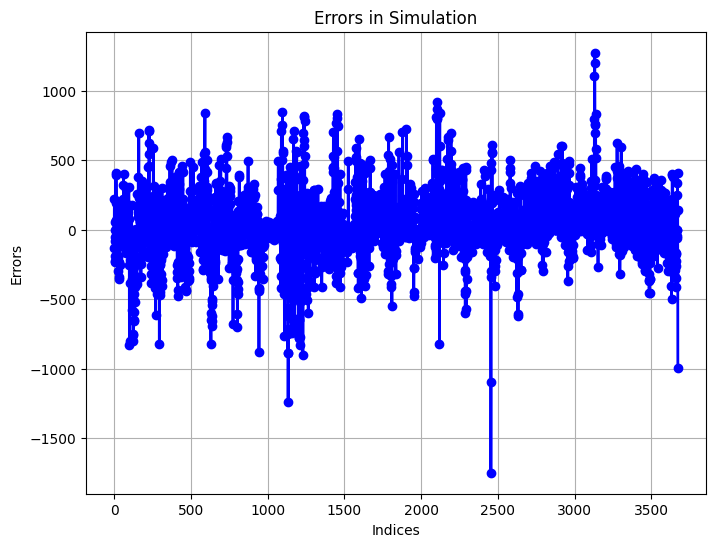

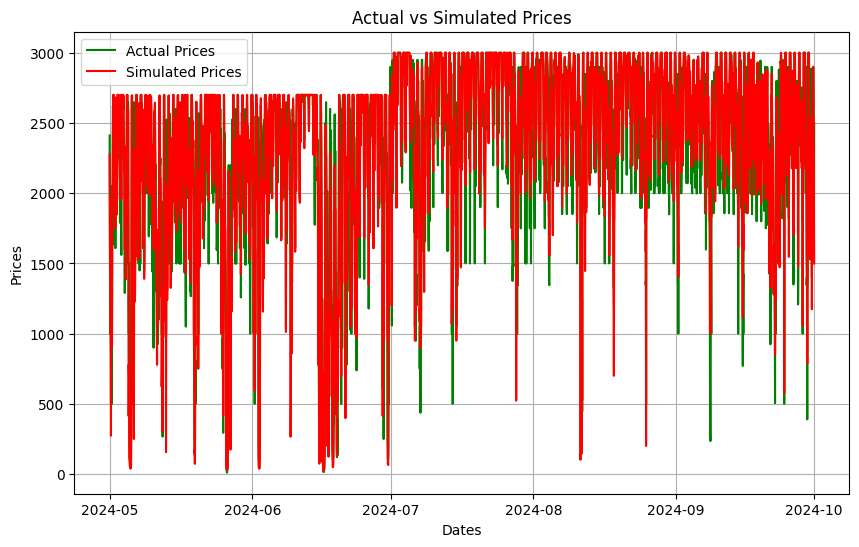

In [4]:
if len(actual_prices) > 0:
    errors = [sim - act for sim, act in zip(simulated_prices, actual_prices)]
    
    plt.figure(figsize=(8, 6))
    plt.plot([i+1 for i in range(len(errors))], errors, marker='o', color='blue', linestyle='-', linewidth=2, markersize=6)
    plt.title("Errors in Simulation")
    plt.xlabel("Indices")
    plt.ylabel("Errors")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(simulation.dates, actual_prices, label='Actual Prices', color='green')
    plt.plot(simulation.dates, simulated_prices, label='Simulated Prices', color='red')
    plt.legend()
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.title('Actual vs Simulated Prices')
    plt.grid(True)
    plt.show()

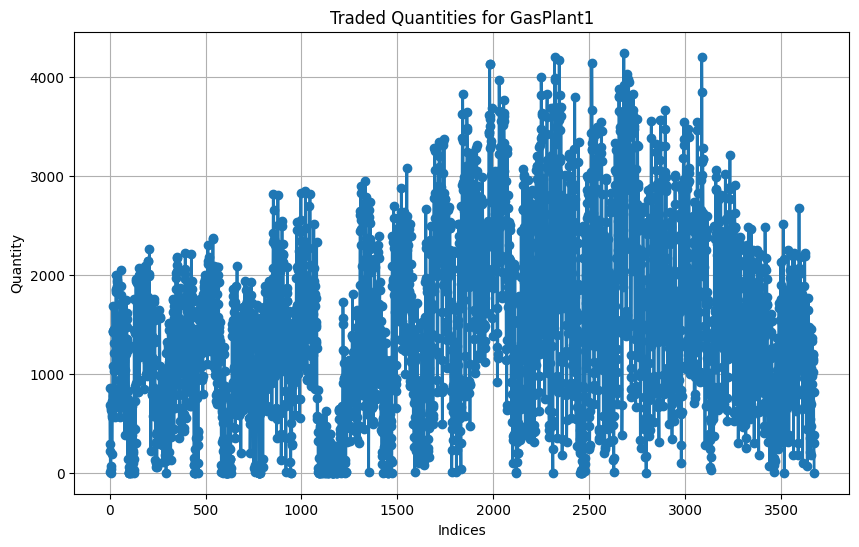

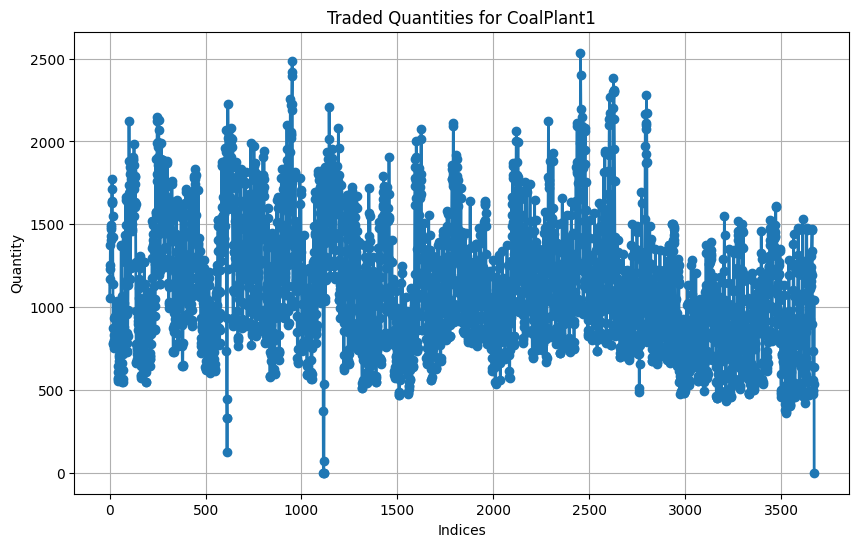

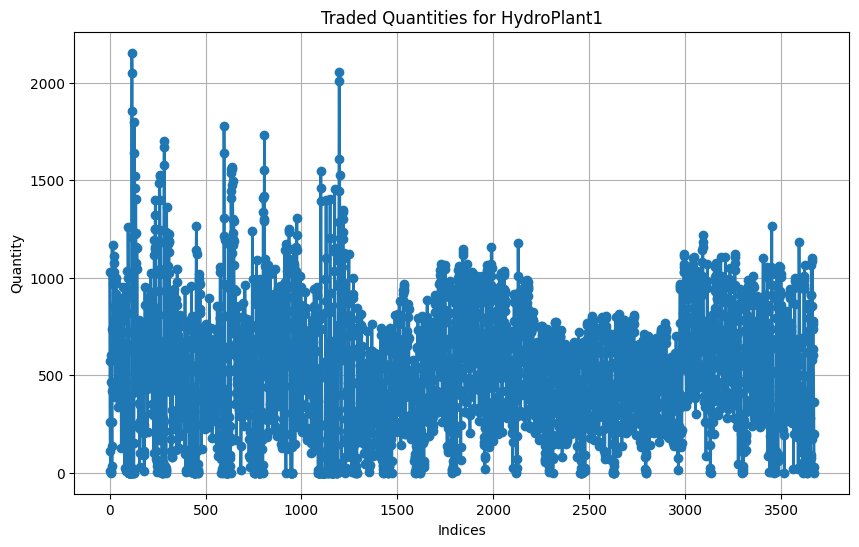

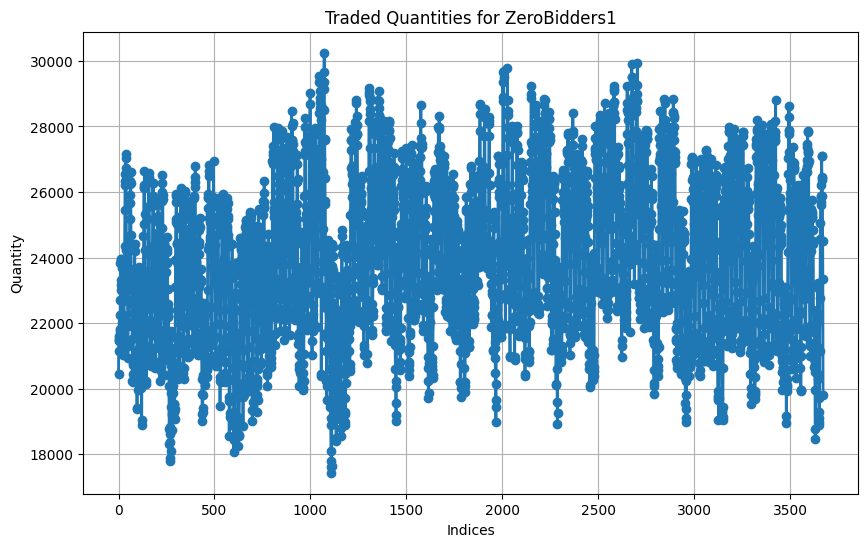

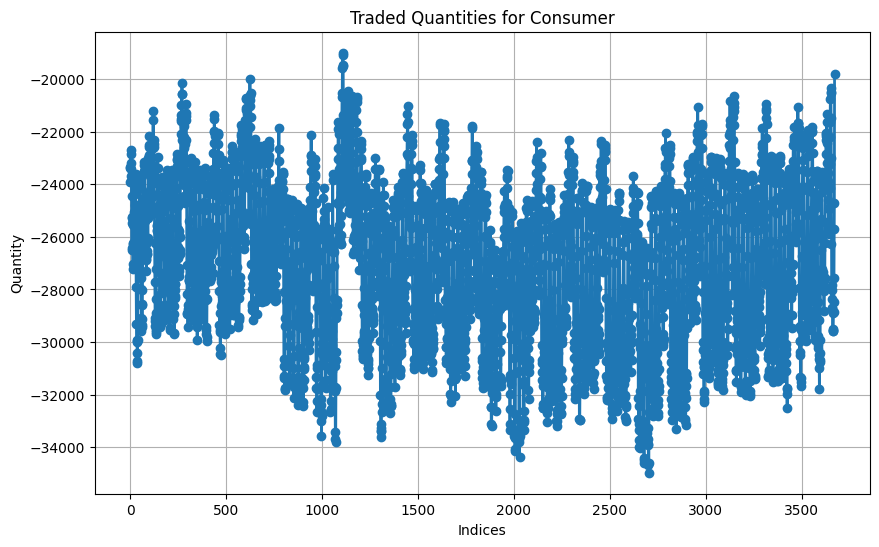

In [5]:
for agent_name in df_results['Agent'].unique():
    agent_data = df_results[df_results['Agent'] == agent_name].reset_index(drop=True)            
    plt.figure(figsize=(10, 6))
    plt.plot(agent_data.index, agent_data['Quantity'], marker='o', linestyle='-', linewidth=2, markersize=6)
    plt.title(f'Traded Quantities for {agent_name}')
    plt.xlabel('Indices')
    plt.ylabel('Quantity')
    plt.grid(True)
    plt.show()